# PARTIE 2 : Modelisation 

Notre démarche dans cette partie modelisation se veut fondamentalement scientifique. Elle se structure autour de la volonté d'atteindre un objectif simple : obtenir un modele avec les meilleures performances possibles dans la classification de categories de vetements que nous avons prédéfinies.

L'idée etant d'avoir une web app de *proof-of-concept* apportant une vraie valeur ajoutée *out-of-the-box*.

Tout au long de cette partie, nous utiliserons la librairie *fastai* construite sur *pytorch*

* Notre démarche se structurera, progressivement, autour de ces points:
  1. Choix du model - Elements Théoriques en faveur du CNN
  2. Stratégie d'optimisation du CNN - Transfert 
  Learning
  3. Acquisition des données - Preprocessing
  4. Apprentissage :
    * Premiere Iteration - Hyperparametres de bases
    * Deuxieme Iteration - Optimisation des hyperparametres
    * Iteration Finale - On exploite les caracteristiques de la derniere itération pour avoir des resultats finaux optimaux
  5. Export du modele pour le deployer au sein de la web app



## I - Convolutional Neural Networks : le standard des methodes de Deep Learning appliquée à la classification d'images

![Représentation d'un CNN](img_notebook/img3.jpeg)

Un *Convolutional Neural Network* (CNN) est un sous-ensemble des architectures neuronales profonde plus générale permettant le mapping entre features d'une donnée et sa classe.

Il s'avère que le CNN est une architecture conçu spécifiquement pour s'adapter de manière performantes aux données de type image. Elle ouvre  la possibilité d'un meilleur mapping entre features et classe des images de par une structure permettant l'apprentissage et la representation de caractéristiques d'un 'bas niveau' (au niveau des pixels de nos images de vetements) jusqu'a un 'haut niveau' ( contours des habits, formes, composition generale etc). Notre cas d'usage visant à la classification de different types d'images de vetements sied donc parfaitement à l'usage des CNN.

* L'architecture d'un CNN se décompose en un ensemble Feature Learning...
    1. "Ensemble Feature Learning' spécifique au CNN et donc au traitement des problème de Deep Learning sur des images: les deux éléments phares de ce sous-ensemble sont les transformations "convolution" et "pooling";
    2. La transformation de convolution est particulièrement adaptée puisque elle permet de gérer la "haute dimensionnalité" des répresentation informatique des images en tenseur, ici 32 par 32 par 32. ![DCNN1](img_notebook/img4.png)                                        Elle consiste seulement au dot product entre un filtre ( tenseur de paramètres à optimisées via gradient descent comme pour des NN classiques) et une portion de l'image originelle. Cette opération est répétée sur toutes où l'on peut possiblement projeter le filtre sur l'image jusqu'a obtenir une matrice donné appelée feature map.           ![DCNN2](img_notebook/img5.png)                                            On repète ce procédé avec différent filtres pour obtenir une couche de convolution entierement paramétrée. 
    3. La transformation dite Pooling permet de rédure la dimensionnalité de la réprésentation de l'image réduisant ainsi le nombre de paramètre et donc la puissance calculatoire necessaire. Cette transformation s'applique sur chaque feature map indépendamment. Le Max Pooling est une approche communément utilisée dont voici le fonctionnement.               
![DCNN3](img_notebook/img6.png)
    
    
* ... et un ensemble de Classification:
    1. Cet ensemble est complètement analogue aux *Neural Networks* classiques, sur chaque couches des neurones combines des tranformations paramétrées linéaires en entrée et non-linéaire en sortie (Relu, Sigmoïde etc)
    
    2. Une des différences clés c'esr que chaque neurones recoit une transformation linéaire de toutes les features des la couche précédente et donc des données alors que nous venons de montrer que pour la couche de convolution , chaque feature map ne reçoit qu'une partie de l'information de la donnée en entrée du CNN.


## II - Stratégie d'optimisation de notre CNN: Exploitation de la méthode du Transfert Learning

* Pour optimiser la performance de notre CNN à notre cas d'usage, nous n'allons pas nous contenter d'utiliser l'architecture de base.

![Representation Transfert Learning](img_notebook/cnn_rep_tl.png)

* Notre stratégie d'optimisation est d'utiliser la méthode du transfert learning. Celle-ci consiste à utiliser un modèle déjà pré-entrainer sur des données.Ici en l'occurence on utlise un modèle d'architecture **resnet50** qui déjà été entrainer sur plus de 1.5M d'images à catégoriser plus d'un milliers de classe. L'idée est de tirer profit de cette connaissance accumulée par le modèle, nottament sur les premieres couches du CNN qui contiennent les representation de 'bas niveau' et 'moyen niveau' du contenu d'une image.

![Fine Tuning](img_notebook/fine_tuning.png)



* On tire parti de ces connaisances en n'entrainant que les dernieres couches du CNN pré-entrainé en specifiant un output correspond à nos classes, le reste des couches etant "gelées'. La methode de fine-tuning que nous allons utilser va un peu plus loin en selectionnant au hasard une proportions de ces "couches savantes gelées" pour les réentrainées.


## III - Acquisition des données

### Imports

In [1]:
# Installation automatique de tous les modules necessaires au point fonctionnement du notebook
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 18.3MB/s 
     |████████████████████████████████| 1.1MB 51.8MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 194kB 62.8MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *

### Création de l'objet DataBlock 
* Détecte directement le jeu d'entrainement et de validation des données apres specification de ses caractéristiques, on choisira notamment:
  * Un split aléatoire (reproductible) 80/20 entre données *train* et *valid*
  * L'application d'une transformation sur les images pour avoir un format d'input uniforme (128x128 px)
* Labellisation des images automatique sur les différentes classes d'habits faite de par la présence des données dans des sous-répertoire éponymes ( permise par notre stratégie de *web-scraping*)


### Acces au repertoire d'intérêt

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
cd drive/MyDrive/ENSAE/

/content/drive/MyDrive/ENSAE


In [5]:
clothes_types = ['pantalon', 'pull', 'short','tshirt']
path = Path('python_project_dataset')

### Verification de la présence des données au sein du dataset

In [6]:
files = get_image_files(path)
files

(#3571) [Path('python_project_dataset/pantalon/h8c15536795779102.jpg'),Path('python_project_dataset/pantalon/h8b15492023812126.jpg'),Path('python_project_dataset/pantalon/hb416148784250910.jpg'),Path('python_project_dataset/pantalon/h3216189304569886.jpg'),Path('python_project_dataset/pantalon/hf216101675597854.jpg'),Path('python_project_dataset/pantalon/hfc16134277169182.jpg'),Path('python_project_dataset/pantalon/h9916148616151070.jpg'),Path('python_project_dataset/pantalon/h6215037063430174.jpg'),Path('python_project_dataset/pantalon/h5716298037903390.jpg'),Path('python_project_dataset/pantalon/hca15491522002974.jpg')...]

### Verification de la non corruption de ces images (pouvant arriver lors du *web-scraping*)

In [7]:
# toutes les données sont intègres : on va pouvoir les specifier notre objet DataBlock et les chargées.
corrupt = verify_images(files)
corrupt

(#0) []

### Specification de l'objet DataBlock

In [8]:
# (image data, label) key value pairing
# split 80/20, tfms resize 128x128 px
# seed pour la reproductibilité des résultats
clothes = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [9]:
# chargement des données
dls = clothes.dataloaders(path)


### Visualisation de notre dataset
* Visualisation d'un segment aléatoire de nos données dans une matrice carrée de dimension (4,5)
* On peut vérifier qu'a chaque image est bien associé  correctement à son label

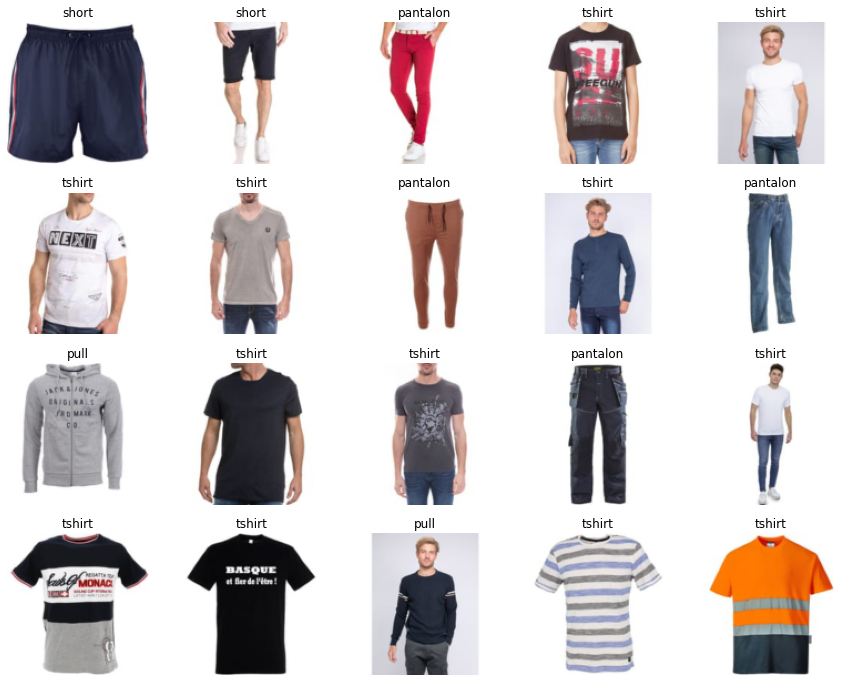

In [13]:
dls.show_batch(max_n=20)

### Preprocessing des données : procedure de Data Augmentation

* On augmente artificiellement la taille de notre dataset en incluant pour chaque images un ensemble de distorsions cadrées aleatoirement

* Cette procedure a de nombreux avantages, elle donne notamment lieu à la reduction de l'apprentissage du *bruit* present dans le training set pour se focaliser sur le *signal* : l'algorithme aura tendance a extraire les caracterisiques fondamentales permettant la reconnaissance d'un habit et sera moins sensible à l'angle de prise de vue.

In [14]:
# data augmentation
clothes = clothes.new(
                item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                batch_tfms=aug_transforms(mult=2)
               )
dls = clothes.dataloaders(path)

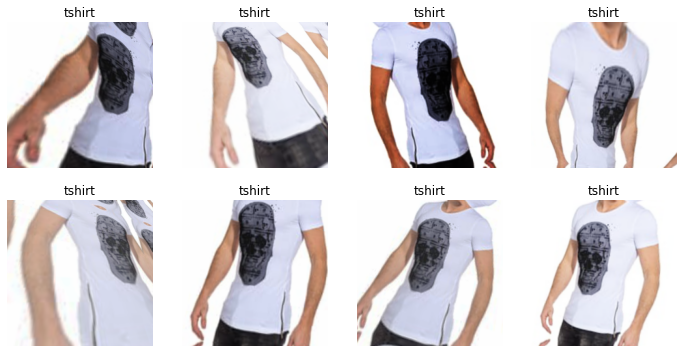

In [15]:
# visualisation d'une des 16 transformations pour une image du dataset
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## IV -  Apprentissage - Transfert Learning sur une architecture Resnet50

### Creation de l'objet learn
* Renferme l'architecture de notre modèle et permet de précharger les poids de restnet50
* Nous utiliserons :
  * l'approche *fine tune* expliquée en introduction de cette partie
  * la metrique *accuracy* pour la validation de nos resultats : proportion des images correctement labelisées au sein du *validation set*.
  * un callback pour evaluer plus finement les performances du modele ( notamment du point de vue de *l'overfitting*



In [17]:
from fastai.test_utils import *

In [19]:
learn = cnn_learner(dls,models.resnet50,metrics=accuracy,cbs=ShowGraphCallback())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### 1. Premiere itération - hyperparametres stocks


#### Caracteristiques de cette premiere itération

* On utilise la methode *fine tune*
* On fait 4 cycles sur les données c'est à dire 4 épochs
* Hyperparametres *stocks* du modele 

epoch,train_loss,valid_loss,accuracy,time
0,1.315817,0.570903,0.868347,00:30


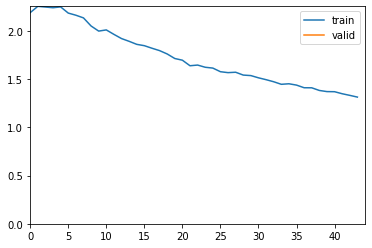

epoch,train_loss,valid_loss,accuracy,time
0,0.631898,0.365510,0.911765,00:39
1,0.452044,0.325604,0.910364,00:41
2,0.340050,0.224134,0.934174,00:41
3,0.266852,0.208754,0.941176,00:41


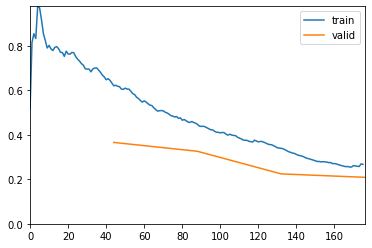

In [20]:
learn.fine_tune(4)

##### La perte sur le validation set est de manière consistante sous la perte sur le training set. Le modele à donc une excellente capacité de généralisation et n'overfit pas. **Le resultat de 94% d'accuracy est donc robuste.**



### 2. Deuxième itération - optimisation des hyperparametres



Nous cherchons à ameliorer encore nos resultats dejà excellents en tirant partie des methodes d'optimisation hyperparametrique.

#### Utilisation de la méthode de Smith  pour l'optimisation du learning rate

*taux d'apprentissage cycliques de Leslie Smith* implementé au sein de **fastai**

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=3.981071586167673e-06)

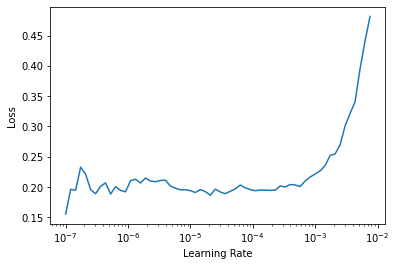

In [21]:
learn.lr_find()

Cette méthodologie vise à modifier notre CNN en lui attribuant un $lr$ qui change de manière cyclique pour chaque lot, au lieu d'un $lr$ non cyclique qui est soit constant, soit changeant à chaque epoch. Cet optimisateur nous suggere un taux de base $lr^{*} = 2.0892961401841602e-06$

#### On entraine desormais le modèle avec $lr^{*}$

* On utilise la methode *fine tune*
* On fait 4 cycles sur les données c'est à dire 4 épochs
* On intègre $lr^{*}$ en tant que learning rate 

epoch,train_loss,valid_loss,accuracy,time
0,0.223017,0.208435,0.941176,00:32


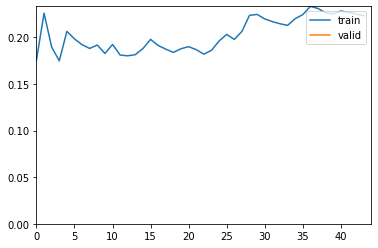

epoch,train_loss,valid_loss,accuracy,time
0,0.194639,0.201414,0.935574,00:41
1,0.208702,0.207216,0.939776,00:41
2,0.204908,0.202461,0.941176,00:41
3,0.192721,0.198424,0.936975,00:41


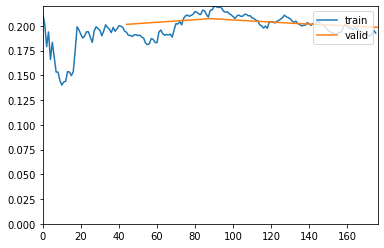

In [22]:
learn.fine_tune(4,base_lr=2.0892961401841602e-06)

On observe une amelioration marginale faible de nos resultats. On constate meme un léger overfiting. Il semblerait qu'on soit arriver aux limites d'amelioration.

#### Evaluation plus avancée des performances de cette deuxieme itération

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

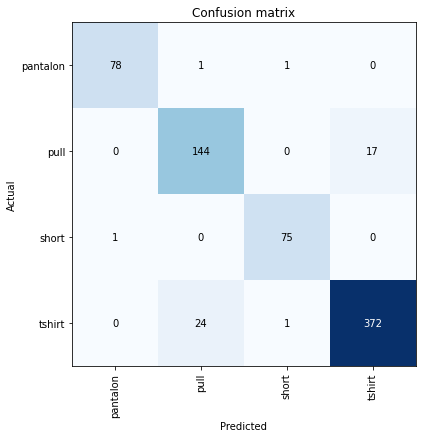

In [24]:
interp.plot_confusion_matrix(figsize=(6,6))

In [25]:
interp.most_confused()

[('tshirt', 'pull', 24),
 ('pull', 'tshirt', 17),
 ('pantalon', 'pull', 1),
 ('pantalon', 'short', 1),
 ('short', 'pantalon', 1),
 ('tshirt', 'short', 1)]

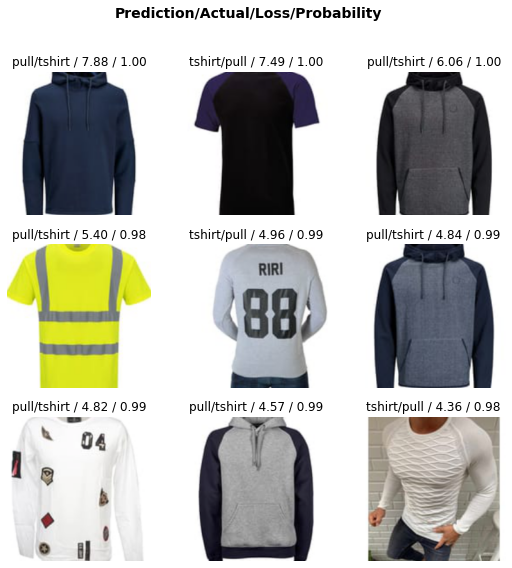

In [26]:
interp.plot_top_losses(9, nrows=3)

### 3. Itération finale - Nettoyage de la BDD + Optimisation des hyperparametres



### Acquisition des données nettoyée en conséquence + Preprocessing

In [34]:
clothes_types = ['pantalon', 'pull', 'short','tshirt']
path = Path('python_project_dataset_final')

In [35]:
files = get_image_files(path)
files

(#3500) [Path('python_project_dataset_final/pantalon/h5716298037903390.jpg'),Path('python_project_dataset_final/pantalon/h9916148616151070.jpg'),Path('python_project_dataset_final/pantalon/hca15491522002974.jpg'),Path('python_project_dataset_final/pantalon/hf216101675597854.jpg'),Path('python_project_dataset_final/pantalon/h6215037063430174.jpg'),Path('python_project_dataset_final/pantalon/h3216189304569886.jpg'),Path('python_project_dataset_final/pantalon/h8b15492023812126.jpg'),Path('python_project_dataset_final/pantalon/h8c15536795779102.jpg'),Path('python_project_dataset_final/pantalon/hfc16134277169182.jpg'),Path('python_project_dataset_final/pantalon/hb416148784250910.jpg')...]

In [36]:
# (image data, label) key value pairing
# split 80/20, tfms resize 128x128 px
# seed pour la reproductibilité des résultats
clothes = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [37]:
# chargement des données
dls = clothes.dataloaders(path)


In [38]:
# data augmentation
clothes = clothes.new(
                item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                batch_tfms=aug_transforms(mult=2)
               )
dls = clothes.dataloaders(path)

In [39]:
learn = cnn_learner(dls,models.resnet50,metrics=accuracy,cbs=ShowGraphCallback())

#### Utilisation de la méthode de Smith  pour l'optimisation du learning rate

*taux d'apprentissage cycliques de Leslie Smith* implenté au sein de **fastai**

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0063095735386013985)

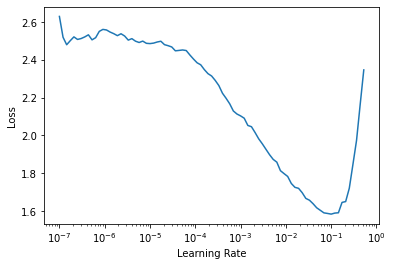

In [40]:
learn.lr_find()

#### On entraine desormais le modèle avec $lr^{*}$

* On utilise la methode *fine tune*
* On fait 4 cycles sur les données c'est à dire 4 épochs
* On intègre $lr^{*}$ en tant que learning rate 

epoch,train_loss,valid_loss,accuracy,time
0,1.040287,0.321716,0.900000,01:53


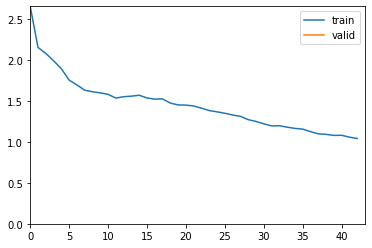

epoch,train_loss,valid_loss,accuracy,time
0,0.451639,0.238888,0.915714,00:41
1,0.357759,0.322649,0.920000,00:40
2,0.277911,0.175337,0.944286,00:40
3,0.201458,0.152863,0.948571,00:40


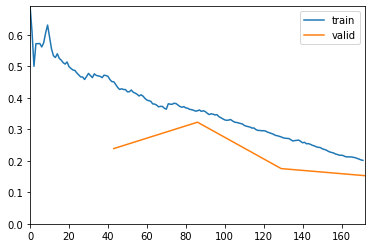

In [41]:
learn.fine_tune(4,base_lr=0.010000000149011612)

Nous tendons vers **95% d'accuracy** et ces resultats robustes. On pouura plus ameliorer grandement les resultats


## V - Export du meilleur modele en vue du deploiement sur la *web-app*


In [42]:
learn.export('export.pkl')

# PARTIE 3 : Architecture de la Web App

![Architecture Web App](img_notebook/web_app.png)

* Le schema ci-dessus represente l'architecture que nous avons mis en place pour permettre l'annotation en ligne des images de vetements. Cette application est conçue pour fonctionner à la fois sur smartphone et desktop/laptop.

* L'idée etant d'avoir une web app de *proof-of-concept* apportant une vraie valeur ajoutée *out-of-the-box*.

* La structure du projet est la suivante :

    1. Le code au sein du repository github est articulé au sein d'une image docker:
        * Dockerfile (contenant les instructions au server pour l'installation de l'environnement)
        * requierments.txt contenant les modules necessaires à l'inférence (fastai,pytorch) et au serveur (univicorn,starlette)
    2. Celle-ci se voit envoyée et deployée sur un serveur hebergé par render.
       (on passe les détails de mise en place qui sont besogneux)
    3. Lorsque le serveur est deployé, il sert la page d'accueil de AiDress et reste en attente d'une POST request contenant une image venant du formulaire d'analyse.
    4. L'image est reçue sur le serveur en BASE64, elle est convertie au format jpeg adequat et envoyée sur le modele prechargé pendant la phase d'initialisation.
    5. Le modele produit une inférence qui est renvoyée directement sur le front end via une POST request et affichée. L'utilisateur voit son image annotée !


In [1]:
!PWD

/Users/zakariabekkar/Documents/AiDress
